## Task 3: MNIST Classification and Analysis

1. Train on the MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test set contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images, but the test set remains the same 10,000 images. Compare against Random Forest (RF) and Logistic Regression models. The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?

2. Let us assume your MLP has 30 neurons in the first layer, 20 in the second layer, and then 10 neurons in the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?

3. Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE visualization for the second layer) compare for MNIST and Fashion-MNIST images?


### Importing Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.4.0+cu124
Using GPU, device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# define a function to set all seeds
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(0)

### Loading the MNIST Dataset

In [4]:
from load_datasets import load_mnist

train_dataset, test_dataset = load_mnist()

# Flatten the images for sklearn MLP
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


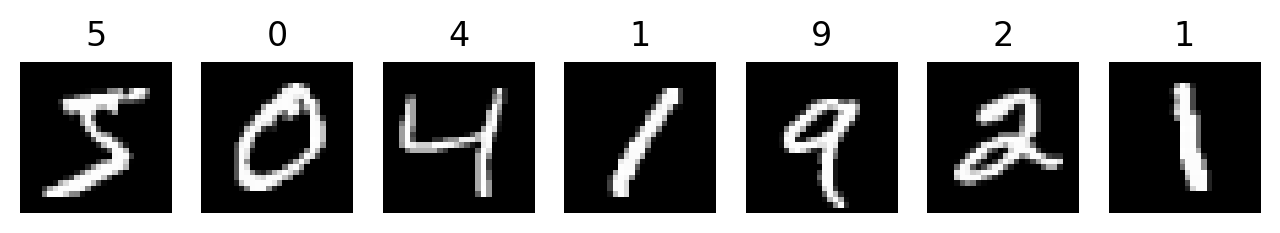

In [5]:
# Plot first few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')


## **MLP model**

In this section, we train a simple MLP model on the MNIST dataset of handwritten digits. The architecture of the MLP is as follows:

| Layer | Number of neurons |
|------------|----------|
| Input Layer | 784 neurons |
| Hidden Layer 1 | 500 neurons |
| Output Layer | 10 neurons |

We use the cross-entropy loss function and Adam as the optimizer. We have used ReLU as the activation function for the hidden layer and softmax for the output layer. The loss function expects logits that's why the softmax hasnt been applied in the neural network.

In [6]:
# Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 60
batch_size = 128
learning_rate = 0.0005


# # next best
# input_size = 784
# hidden_size = 500
# num_classes = 10
# num_epochs = 100
# batch_size = 256
# learning_rate = 0.0008


In [7]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for image classification.

    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        relu (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Second fully connected layer for output.
    """

    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):
        # Flatten the image 
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        output = self.fc2(x)       # No activation here; we'll apply softmax in the loss function
        return output

In [11]:
# Initialize the model
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

summary(model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                   [-1, 10]           5,010
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.52
Estimated Total Size (MB): 1.53
----------------------------------------------------------------


### Train and Predict Functions

In [ ]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        y_train_pred = []  # Reset predictions for each epoch
        y_train_true = []  # True labels for each epoch
        y_train_prob = []  # Predicted probabilities for each epoch

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Store predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            y_train_pred.extend(predicted.cpu().numpy())
            y_train_true.extend(labels.cpu().numpy())
            y_train_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = total_train_loss / len(train_loader)
        
        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        
        y_test_pred = []  # Reset test predictions for each epoch
        y_test_true = []  # True labels for test set
        y_test_prob = []  # Predicted probabilities for test set

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                y_test_pred.extend(predicted.cpu().numpy())
                y_test_true.extend(labels.cpu().numpy())
                y_test_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

    return model, train_loss, train_accuracy, test_loss, test_accuracy, y_train_true, y_train_pred, y_train_prob, y_test_true, y_test_pred, y_test_prob


def predict_model(model, test_loader):
    model.eval()
    y_test_pred = []
    y_test_true = []
    y_test_prob = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_test_pred.extend(predicted.cpu().numpy())
            y_test_true.extend(labels.cpu().numpy())
            y_test_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

    return y_test_true, y_test_pred, y_test_prob


### Training the MLP model

In [12]:
# Train and evaluate the model
model, train_loss, train_accuracy, test_loss, test_accuracy, y_train, y_train_pred, y_train_prob, y_test, y_test_pred, y_test_prob = train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch [10/60], Train Loss: 0.028951, Train Accuracy: 99.2550%, Test Loss: 0.063283, Test Accuracy: 97.9700%
Epoch [20/60], Train Loss: 0.004273, Train Accuracy: 99.9517%, Test Loss: 0.070219, Test Accuracy: 97.9800%
Epoch [30/60], Train Loss: 0.004715, Train Accuracy: 99.8650%, Test Loss: 0.076466, Test Accuracy: 98.0600%
Epoch [40/60], Train Loss: 0.006903, Train Accuracy: 99.7850%, Test Loss: 0.082665, Test Accuracy: 98.1800%
Epoch [50/60], Train Loss: 0.000081, Train Accuracy: 100.0000%, Test Loss: 0.086512, Test Accuracy: 98.2900%
Epoch [60/60], Train Loss: 0.000061, Train Accuracy: 100.0000%, Test Loss: 0.092287, Test Accuracy: 98.2700%


In [25]:
y_train, y_train_pred, y_train_prob = predict_model(model, train_loader)
y_test, y_test_pred, y_test_prob = predict_model(model, test_loader)

### MLP Performance Metrics

Train F1 Score: 1.0000
Test F1 Score: 0.9826

Train Accuracy: 100.0000%
Test Accuracy: 98.2700%



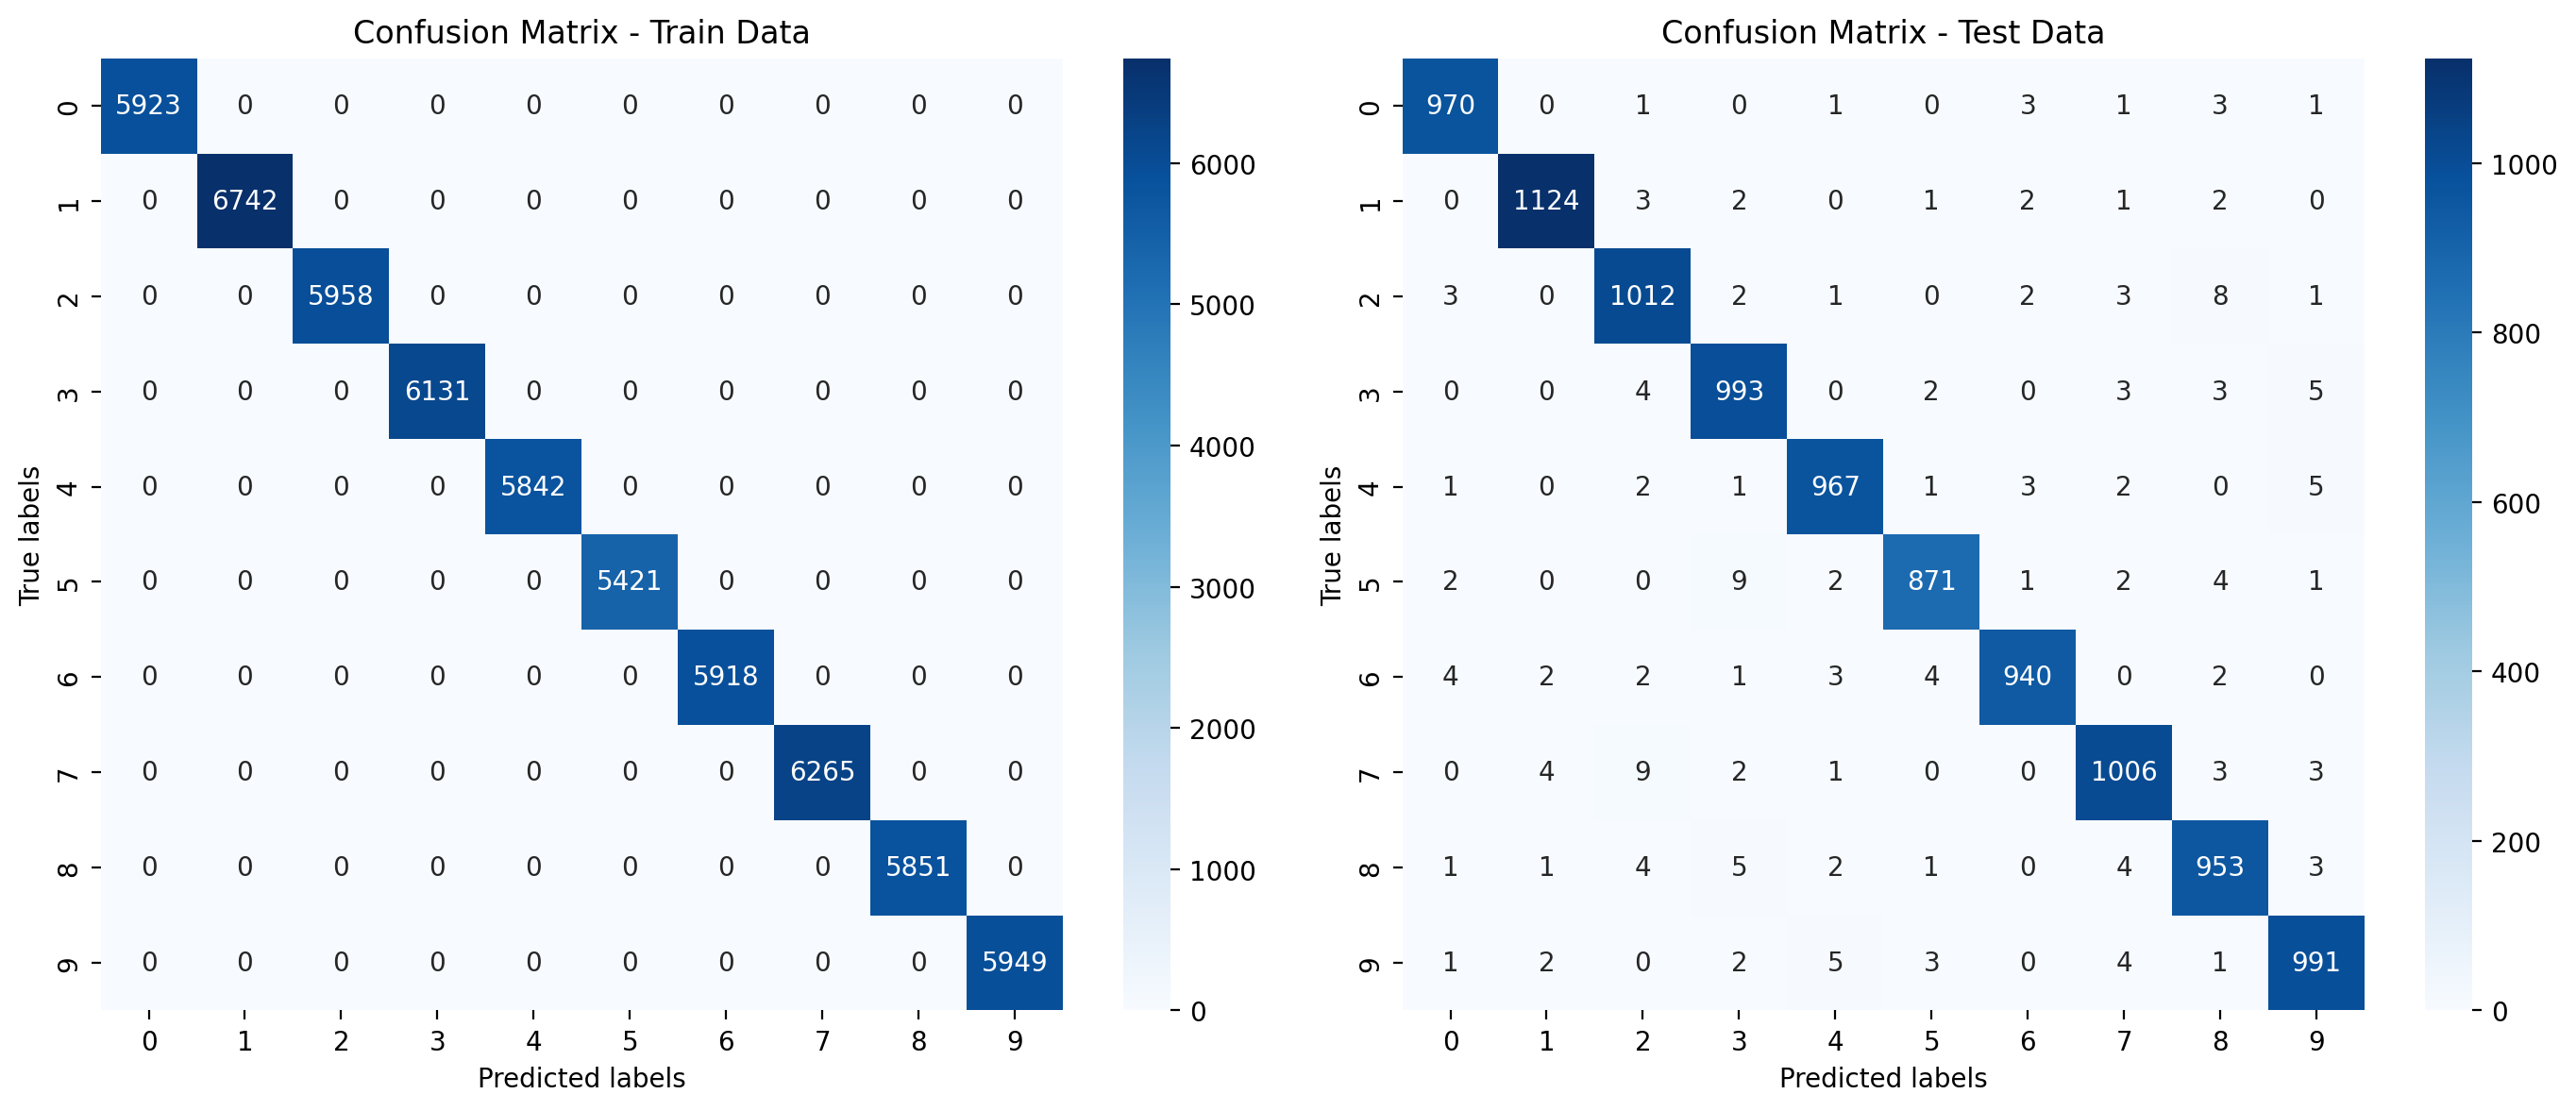

In [26]:
# Calculate F1 scores and confusion matrix
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(f'Train F1 Score: {f1_train:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'\nTrain Accuracy: {train_accuracy:.4f}%')
print(f'Test Accuracy: {test_accuracy:.4f}%\n')

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [27]:
# plot classification report
# print('Train Data Classification Report:')
# print(classification_report(y_train, y_train_pred))
print('Test Data Classification Report:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Displaying the first 9 wrongly classified images with highest probability

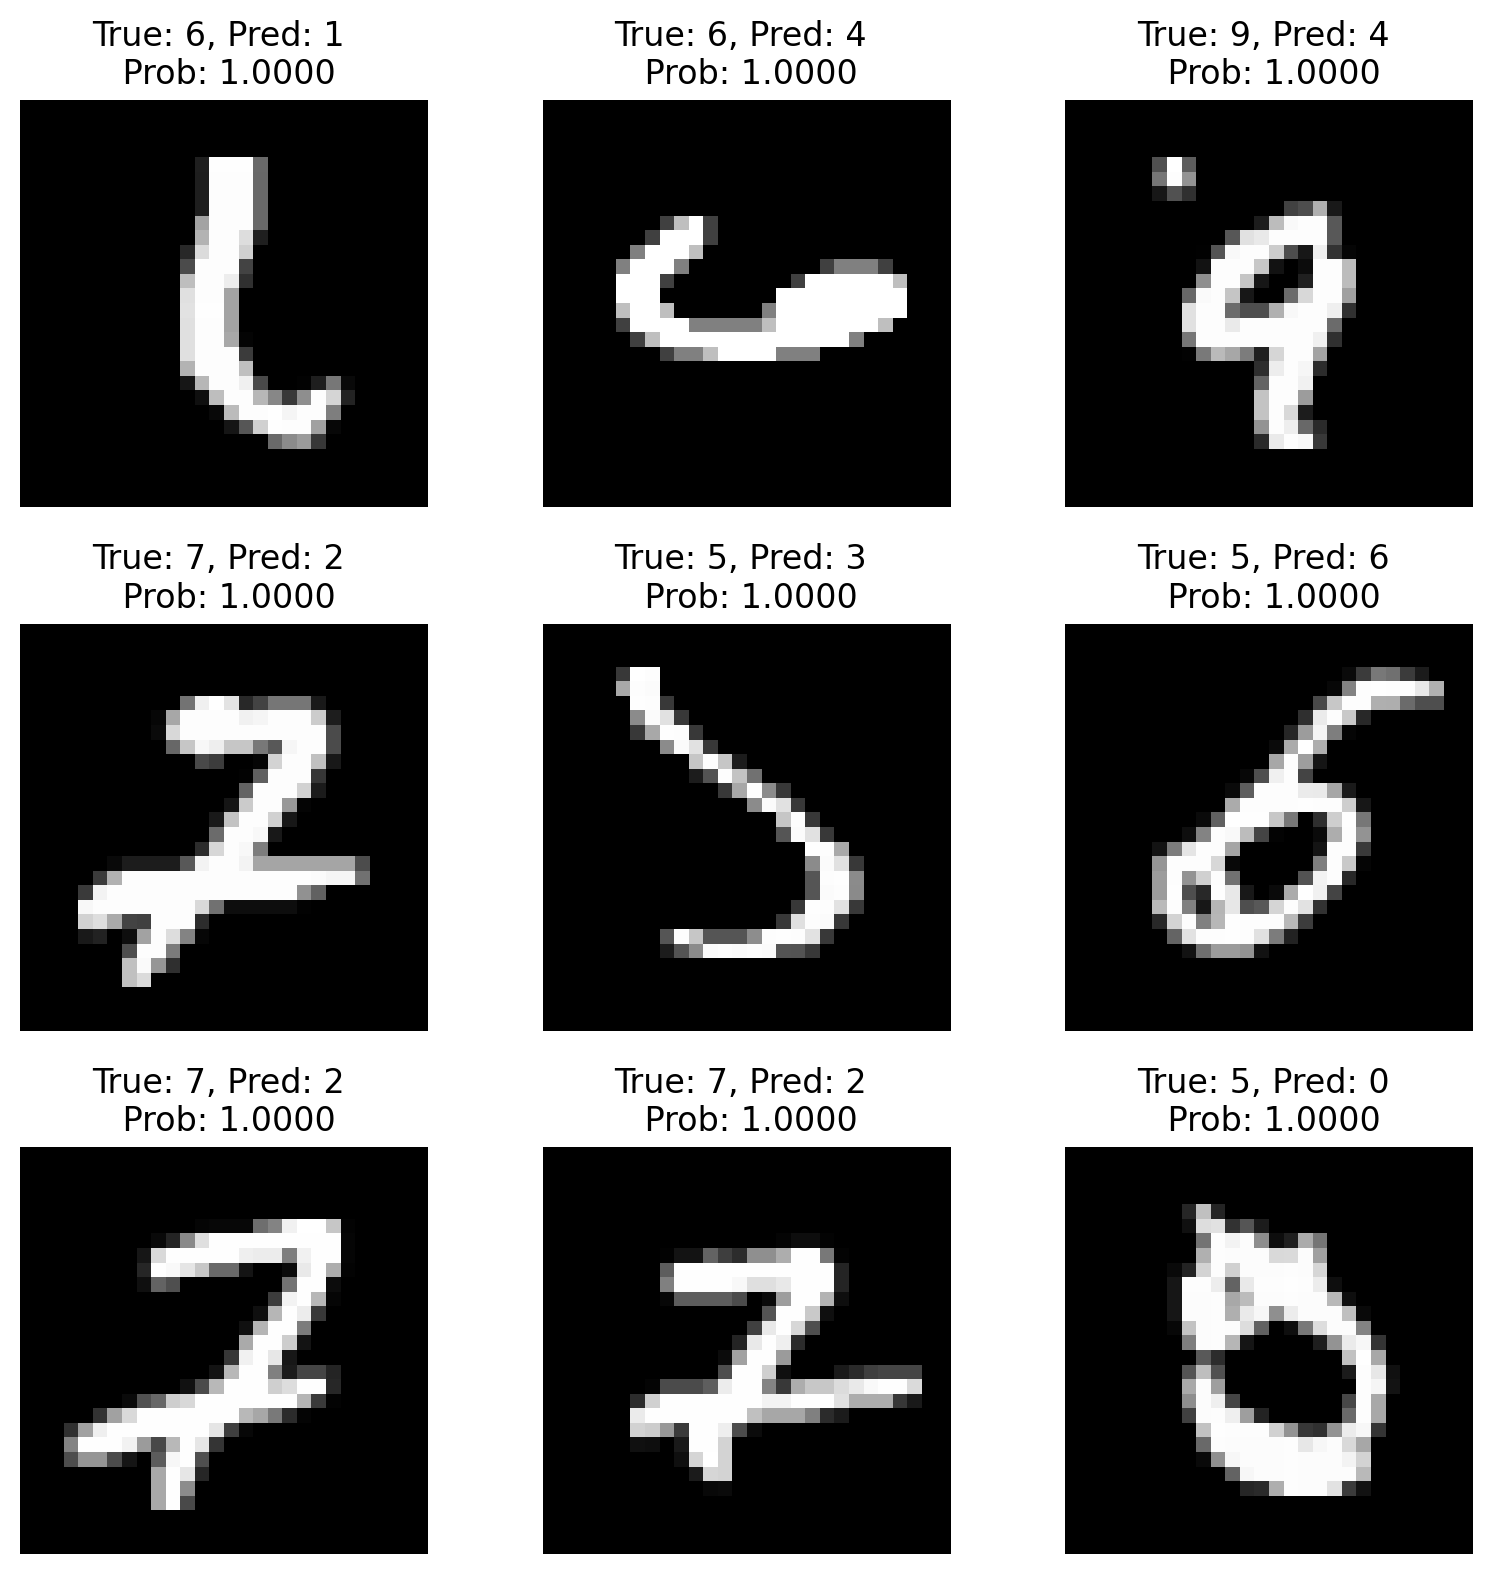

In [28]:
# Display the first k wrongly classified images with highest probability
k = 9
wrong_indices = np.where(np.array(y_test) != np.array(y_test_pred))[0]
wrong_prob = np.array(y_test_prob)[wrong_indices]
wrong_prob_max = np.max(wrong_prob, axis=1)
wrong_prob_indices = np.argsort(wrong_prob_max)[::-1][:k]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, idx in enumerate(wrong_prob_indices):
    ax = axs[i // 3, i % 3]
    ax.imshow(X_test[wrong_indices[idx]], cmap='gray')
    ax.set_title(f'True: {y_test[wrong_indices[idx]]}, Pred: {y_test_pred[wrong_indices[idx]]} \n Prob: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), '../models/task-3/mlp_model_98_27.ckpt')

# Load the model checkpoint
model = MLP(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('../models/task-3/mlp_model_98_27.ckpt'))

C:\Users\Shardul Junagade\AppData\Local\Temp\ipykernel_2464\2837035765.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/mlp_mod

<All keys matched successfully>

## **Random Forest and Logistic Regression**

### Training the Random Forest model

In [ ]:
# Convert training data to numpy arrays
X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1)
y_train = train_dataset.targets.numpy()

# Convert test data to numpy arrays
X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1)
y_test = test_dataset.targets.numpy()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

print(f'Random Forest accuracy: {np.mean(y_rf_pred == y_test)}')

Random Forest accuracy: 0.9705


In [ ]:
# rf_model save
joblib.dump(rf_model, '../models/task-3/rf_model.pkl')

['./models/rf_model.pkl']

### Training the Logistic Regression model

In [ ]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_model.fit(X_train_scaled, y_train)
y_lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression accuracy: {np.mean(y_lr_pred == y_test)}')

Logistic Regression accuracy: 0.9221


In [ ]:
# lr_model save
joblib.dump(lr_model, '../models/task-3/lr_model.pkl')

['./models/lr_model.pkl']

### Performance Metrics

In [ ]:
# F1 score and confusion matrix for Random Forest
f1_rf = f1_score(y_test, y_rf_pred, average='macro')

# F1 score and confusion matrix for Logistic Regression
f1_lr = f1_score(y_test, y_lr_pred, average='macro')

# Print F1 scores
print(f'Random Forest F1 Score: {f1_rf:.4f}')
print(f'Logistic Regression F1 Score: {f1_lr:.4f}')


Random Forest F1 Score: 0.9702
Logistic Regression F1 Score: 0.9211


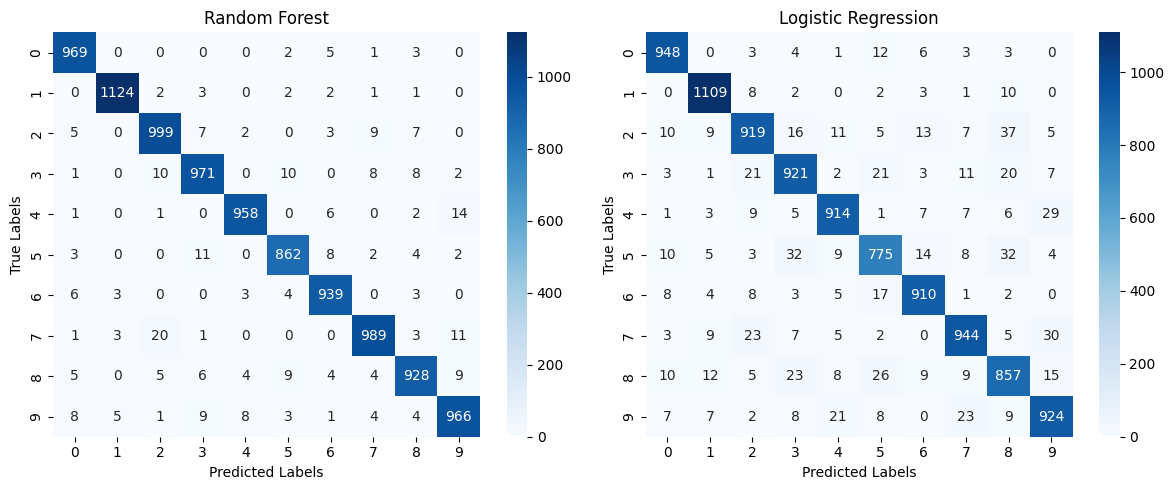

In [ ]:
cm_rf = confusion_matrix(y_test, y_rf_pred)
cm_lr = confusion_matrix(y_test, y_lr_pred)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Random Forest')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Logistic Regression')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


In [ ]:
# classification reports
print('Random Forest Classification Report')
print(classification_report(y_test, y_rf_pred))
print("-"*50)
print('\nLogistic Regression Classification Report')
print(classification_report(y_test, y_lr_pred))


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

--------------------------------------------------

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
  

## Comparison between MLP, Random Forest and Logistic Regression

**Performance Metrics**

The table below shows the accuracy and F1 score on the test set provided in the MNIST dataset for all the three models:

| Model      | Accuracy | F1 Score |
|------------|----------|----------|
| MLP        | 98.27%     | 0.9826    |
| Random Forest   | 97.05%     | 0.9702    |
| Logistic Regression    | 92.21%     | 0.9211     |

**Confusions Matrices**

The confusion matrices for all the models on the test set are shown below:

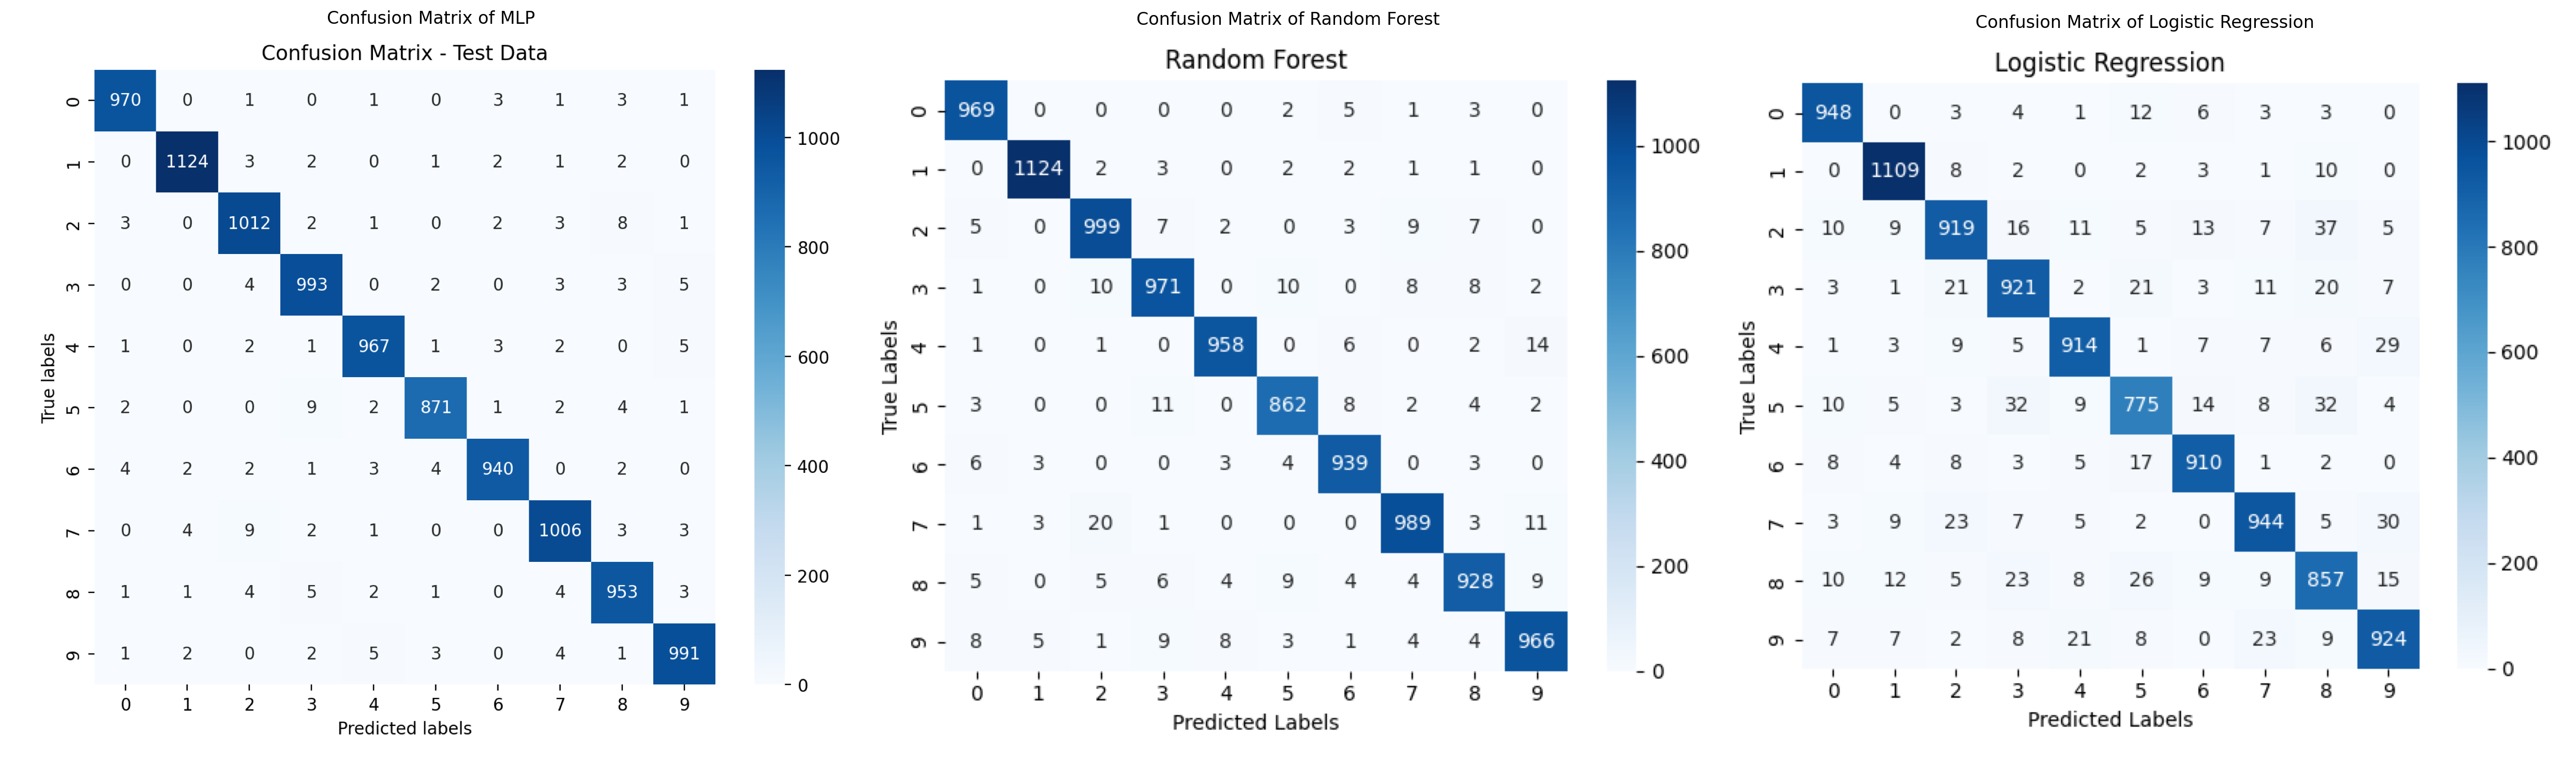

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(25, 15))
img = Image.open("./images/mnist_mlp_cf.png")
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Confusion Matrix of MLP')

img = Image.open("./images/mnist_rf_cf.png")
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Confusion Matrix of Random Forest')

img = Image.open("./images/mnist_lr_cf.png")
axes[2].imshow(img)
axes[2].axis('off')
axes[2].set_title('Confusion Matrix of Logistic Regression')

plt.tight_layout()
plt.show()

### Observations

Based on the confusion matrices and the performance metrics provided, we can make the following observations:

1. **MLP (Multi-Layer Perceptron)**:
    - **Accuracy**: 98.27%
    - **F1 Score**: 0.9826
    - The MLP model has the highest accuracy and F1 score among the three models, indicating that it performs the best on the test set. The confusion matrix shows that the MLP model has the least number of misclassifications.
    - Commonly confused digits - 2 and 7, 3 and 5 (but very less number of misclasssifications)

2. **Random Forest**:
    - **Accuracy**: 97.05%
    - **F1 Score**: 0.9702
    - The Random Forest model also performs well, with a high accuracy and F1 score. However, it has slightly more misclassifications compared to the MLP model, as seen in the confusion matrix.
    - Commonly confused digits - 2 and 7, 3 and 5

3. **Logistic Regression**:
    - **Accuracy**: 92.21%
    - **F1 Score**: 0.9211
    - The Logistic Regression model has the lowest accuracy and F1 score among the three models. The confusion matrix shows that it has the highest number of misclassifications, indicating that it is the least effective model for this dataset.
    - Commonly confused digits - 0 and 4, 0 and 7, 2 and 7, 2 and 8, 3 and 5, 3 and 8, 5 and 8, etc.


### Conclusions

Overall, the MLP model outperforms both the Random Forest and Logistic Regression models in terms of accuracy and F1 score, as well as having fewer misclassifications in the confusion matrix.

- The MLP, being a neural network with multiple layers, has a greater capacity to learn non-linear relationships in the data. This allows it to better differentiate between similar-looking digits and achieve fewer misclassifications.
- As an ensemble method, Random Forests generally perform well due to averaging across many decision trees, which reduces overfitting. However, it lacks the depth of MLP in capturing complex non-linear patterns, which leads to more frequent confusions between similar digits.
- Logistic Regression, as a linear model, is limited in its ability to capture complex patterns, thus making it the least effective for this data.